In [1]:
import pandas as pd
import json
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

In [2]:
# Import as Pandas dataframe
logins = pd.read_json('C:/Users/melin/Documents/Springboard Data Science Career Track/Take-Home Challenge - Ultimate Technologies Inc/1481053515_ultimate_challenge/ultimate_challenge/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


# Part 1 ‑ Exploratory data analysis

## Examine the data

In [3]:
print("Earliest time in database: ", min(logins["login_time"]))
print("Latest time in database: ", max(logins["login_time"]), '\n')

print("Total entries: ", len(logins))

Earliest time in database:  1970-01-01 20:12:16
Latest time in database:  1970-04-13 18:57:38 

Total entries:  93142


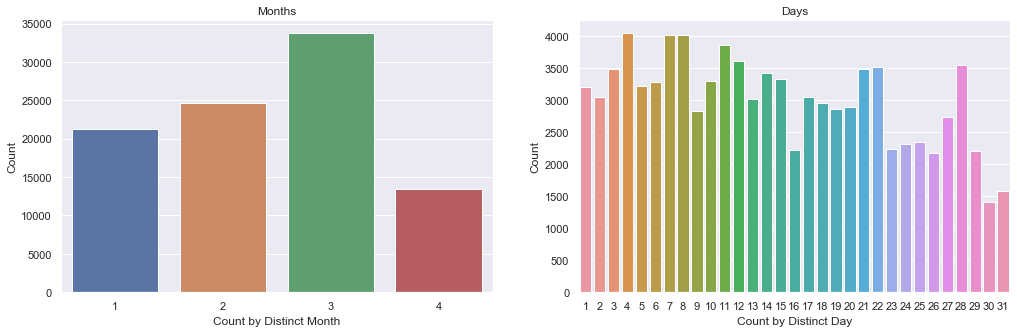

In [4]:
# Analyze data and check for quality issues

datetimes = list(map(lambda x: x.date(), logins['login_time'].tolist())) # extract datetime objects

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) # Convert to dataframe, with separate month & day columns

# Plot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
# Count by month
df1 = df_datetimes.groupby('month').count()
sns.barplot(x=df1.index.tolist(), y="day", data=df1, ax=ax1);
ax1.set(xlabel='Count by Distinct Month', ylabel="Count", title="Months");

# Count by day
df2 = df_datetimes.groupby('day').count()
sns.barplot(x=df2.index.tolist(), y="month", data=df2, ax=ax2);
ax2.set(xlabel='Count by Distinct Day', ylabel="Count", title="Days");

Observations:
- March has the most number of user logins. However, April has the least. It is possible that data collection was truncated before the month ended in April.
- Days 30 and 31 have the least number of user logins.

No obvious data quality issues can be seen.

## Aggregating intervals - 15 min

In [5]:
# Aggregate login counts based on 15-min intervals. 
df = pd.DataFrame.copy(logins) # make copy of dataframe to work with
df.set_index('login_time', inplace=True) # set index to be the timestamps, to allow aggregation
df['count'] = 1 # each timestamp has 1 count
df_15 = df.resample('15T').sum() # aggregate by 15-min intervals
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


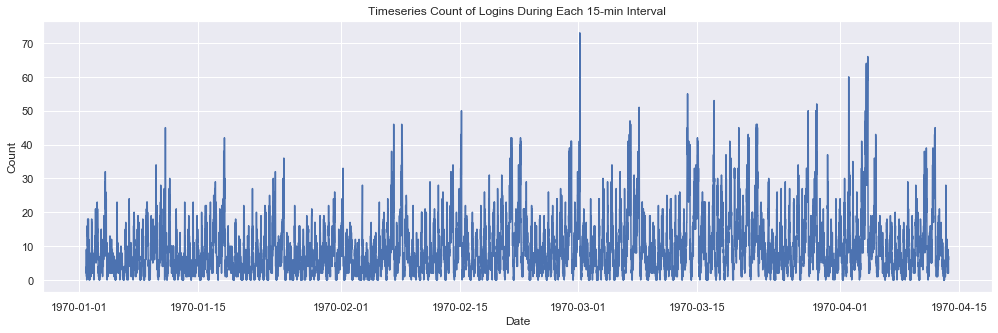

In [6]:
plt.figure(figsize=(17,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timeseries Count of Logins During Each 15-min Interval');

There is a large spike in login counts around the beginning of March. The second largest spike in login counts can be seen close to the beginning of April.

The line plot is too constrained to interpret beyond large chunks of dates. It will be narrowed down to different time-levels to see what more information the data can provide.

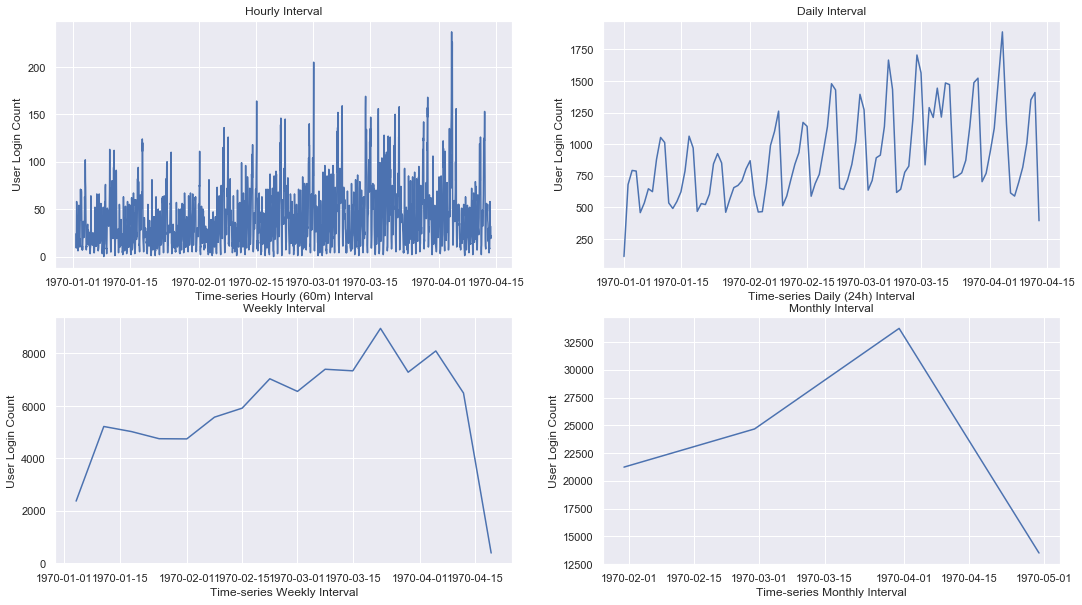

In [7]:
# Plot different time intervals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series Hourly (60m) Interval', ylabel='User Login Count', title='Hourly Interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series Daily (24h) Interval', ylabel='User Login Count', title='Daily Interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series Weekly Interval', ylabel='User Login Count', title='Weekly Interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series Monthly Interval', ylabel='User Login Count', title='Monthly Interval');

On the hourly and daily levels, it's still difficult to picture any patterns due to the constrained x-axises. Even so, a general cyclic pattern can be seen emerging from the "Daily Interval" figure. It seems there might be certain hours of the day at which there are more user logins than other parts of day, and this cycle repeats itself each day even though intensity varies.

#### Visualizing a single day's cycle

Data will be plotted by the hourly intervals of a single day to get a better picture of fluctuations happening throughout the day that couldn't be seen in the previous figures. These fluctuations probably make up a single cycle which were seen repeating each day (albeit with differing intensities). Feb. 4, 2017 is the day randomly chosen to be plotted. 

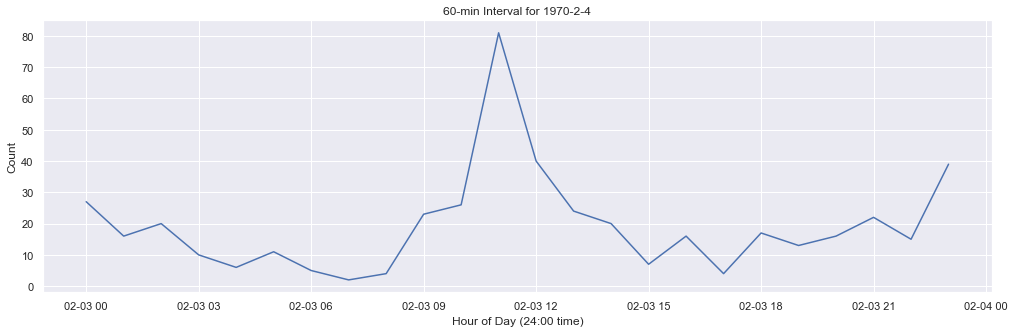

In [8]:
# Extract all logins on Feb 4, 1970
mask = (logins['login_time'] > np.datetime64('1970-02-03')) & (logins['login_time'] <= np.datetime64('1970-02-04'))
df_day = logins[mask]

# Aggregate into 60-min intervals
df = pd.DataFrame.copy(df_day) 
df.set_index('login_time', inplace=True) 
df['count'] = 1 
df_60 = df.resample('60T').sum()

# Plot
plt.figure(figsize=(17,5));
plt.plot(df_60);
plt.xlabel('Hour of Day (24:00 time)');
plt.ylabel('Count');
plt.title('60-min Interval for 1970-2-4');

Now the fluctuations can be easily seen for a single day (Feb. 4, 2017). According to the plot: 
- The morning and evening times have the lowest user login counts. 
- Login counts increase sharply at around 9 AM (likely due to people needing trasnport to arrive at work) and peak right before noon (likely due to people using transport to head to lunch). 
- Then they drop off although they pick up slightly before midnight (likely people using transport to return home from "night outs").

# Part 2 ‑ Experiment and metrics design

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Determine the change in pre and post-reimbursement number of times the driver has crossed the bridge since this will indicate whether there is an increase, decrease, or no change in how often driver partners served both cities after the experiment.

A significant post-reimbursement increase in driver crossings supports the experiment's success as driver partners tended to serve both cities more often after the experiment's introduction.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### a. how you will implement the experiment

Conduct a one-sided, 1-sample z-test, assuming sample size of more than 30 drivers. Compare the number of driver bridge crossings (where a crossing = crossing the bridge + serving crossed-to city) pre and post-reimbursement. 

- $h_0$: No difference in driver bridge crossings, after toll reimbursement experiment.
- $h_a$: Increase in driver bridge crossings, after toll reimbursement experiment.

Null hypothesis distribution is simply the distribution of driver crossings <i>before</i> toll reimbursement experiment.

1. Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment.
2. Set $a$=0.05. Determine if z-score's p-value falls below this significance threshold.

#### b. what statistical test(s) you will conduct to verify the significance of the observation

The p-value of the one-sided, 1-sample z-test will be used to verify the significance of the observation. If the p-value is less than 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.

#### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats

The caveat is that $a$ significance levels are set arbitrarly, and p-values fluctuate depending on the sample size. Thus, depending on how wide of a margin the post-reimbursement increase is, the experiment could either support or reject the policy. 

As a result, it is recommended to only consider the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.

# Part 3 ‑ Predictive modeling

In [9]:
users = json.load(open('C:/Users/melin/Documents/Springboard Data Science Career Track/Take-Home Challenge - Ultimate Technologies Inc/1481053515_ultimate_challenge/ultimate_challenge/ultimate_data_challenge.json')) # load json (produces dict)
users = pd.DataFrame(users) # convert json dict to dataframe
print('Number of users: ', len(users))
users.head()

Number of users:  50000


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [10]:
## Get the cutoff for "retained users" (Users are retained if, at the time of pulling data, they were active in the preceding 30 days.)

from datetime import timedelta
from dateutil import parser

# Get latest date that data was pulled
users['last_trip_date'] = pd.to_datetime(users['last_trip_date']) # convert 'last_trip_date' column to datetime
date_pulled = max(users['last_trip_date']) # get max = approximation of when data was pulled

# Get cutoff for earliest active date to meet "retained" criteria
retain_cutoff = date_pulled - timedelta(days=30)

print("Cut-off for 'retained users': ", retain_cutoff)

Cut-off for 'retained users':  2014-06-01 00:00:00


In [11]:
## Get fraction of observed users retained

retained = users[users['last_trip_date'] >= retain_cutoff]
print("Fraction of observed users retained: ", len(retained) / len(users))

Fraction of observed users retained:  0.37608


In [12]:
## Get users still active in their 6th month in the system

# Set up
users['signup_date'] = pd.to_datetime(users['signup_date']) # convert dates to datetime objects
month_6 = users['signup_date'] + timedelta(days=151) # set minimum date of last ride to qualitfy as "active in their 6th mo"

# Get users active in their 6th month in system
active_idx = [idx for idx, s in enumerate(users['last_trip_date']) if s > month_6[idx]] # their their indices in database

# Append data to our database (useful for data viz later)
users['active'] = 0 # set default to 0
users.loc[active_idx, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_idx))
print("Number of inactive users: ", len(users) - len(active_idx))
print("Percent active users: ", len(active_idx)/len(users))

Number of active users:  11694
Number of inactive users:  38306
Percent active users:  0.23388


Only around 23% of users are active. Accuracy alone can't probably be relied on for determining how effective the model will be. Rather, the metrics such as the percentages of false positives and false negatives will be needed.

In [13]:
# Inspect which columns consist of string values.
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [14]:
# Check number of unique values in each of these columns.
print("city: ", users['city'].unique())
print("phone: ", users['phone'].unique())
print("ultimate_black_user: ", users['ultimate_black_user'].unique())

city:  ["King's Landing" 'Astapor' 'Winterfell']
phone:  ['iPhone' 'Android' None]
ultimate_black_user:  [ True False]


In [15]:
## Convert the strings in the columns to integers

# Convert cities
cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
users['city'] = users['city'].map(lambda x: cities[x])

# Convert phones
phones = {"iPhone": 1, "Android": 2}
users['phone'] = users['phone'].map(lambda i: phones[i] if i is not None else 0)

# Convert ultimate black status
users['ultimate_black_user'] = users['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

In [16]:
# Check for missing values in the users dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  50000 non-null  int64 

In [17]:
# Missing values are replaced with the column's mean.
users['avg_rating_by_driver'].fillna(users['avg_rating_by_driver'].mean(), inplace=True)
users['avg_rating_of_driver'].fillna(users['avg_rating_of_driver'].mean(), inplace=True)

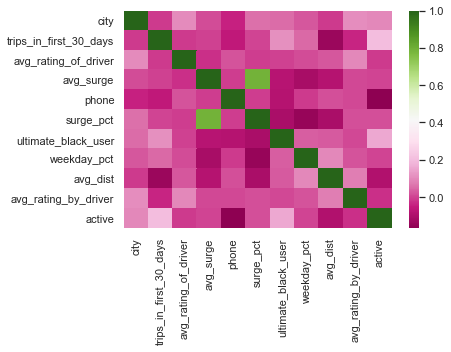

In [18]:
# Check for correlation between variables
# For convenience, the correlation matrix includes a row/column for 'active' users to easily visualize whether any individual variables strongly predict 'active' users.
sns.heatmap(users.corr(), cmap="PiYG");

Based on the correlation matrix, these variables will be dropped out:
- <b>'surge_pct'</b> and <b>'avg_surge':</b> These variables are shown to have a high inter-correlation with each other. This sounds reasonable as users who tend to take trips during a surge will have higher percentages of trips with a surge ('surge_pct') and higher averages of surge ('avg_surge'). However, since neither are strongly correlated with 'active' users, these variables will be dropped to avoid confounding the prediction model.
- <b>'phone':</b> This variable is shown to have the lowest correlation (~0) with 'active' users. Additionally, it might confound the prediction model since its values are encoded by an arbitrary binary conversion, and most of the other variables are continuous.

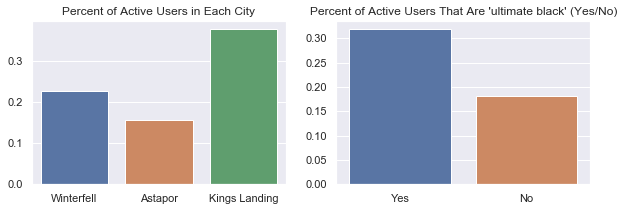

In [23]:
# Inspect the variables 'city' and 'ultimate_black_user' as they are discrete, and discrete variables might confound the prediciton model consisting a majority of continuous variables
# They will be dropped if they don't seem significant in contributing to the prediction of 'active' user

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# % active users by city

df1 = users[users['city']==1]
df2 = users[users['city']==2]
df3 = users[users['city']==3]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)
active3 = len(df3[df3['active']==1])/len(df3)

g = sns.barplot(x = ['Winterfell', 'Astapor', 'Kings Landing'], y = [active1, active2, active3], ax=ax1);
g.set_title('Percent of Active Users in Each City');

# % active users by "ultimate black" status

df1 = users[users['ultimate_black_user']==1]
df2 = users[users['ultimate_black_user']==0]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)

g = sns.barplot(x = ['Yes', 'No'], y = [active1, active2], ax=ax2);
g.set_title("Percent of Active Users That Are 'ultimate black' (Yes/No)");

Even though obvious differences can be seen, it is inconclusive whether or not these differences are significant. Thus, the  'city' and 'ultimate_black_user' variables will be kept.

In [24]:
# Dropping the 'surge_pct', 'avg_surge', and 'phone' variables
# The 'last_trip_date' and 'signup_date' variables will also be dropped since these were used to determine 
# whether the user was active and may no longer be useful. Plus, they could confound the prediciton model.
users.drop(['surge_pct', 'avg_surge', 'phone', 'last_trip_date', 'signup_date'], inplace=True, axis=1)
users.head()

,city,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,3,4,4.7,1,46.2,3.67,5.0,0
1,2,0,5.0,0,50.0,8.26,5.0,0
2,2,3,4.3,0,100.0,0.77,5.0,0
3,3,9,4.6,1,80.0,2.36,4.9,1
4,1,14,4.4,0,82.4,3.13,4.9,0


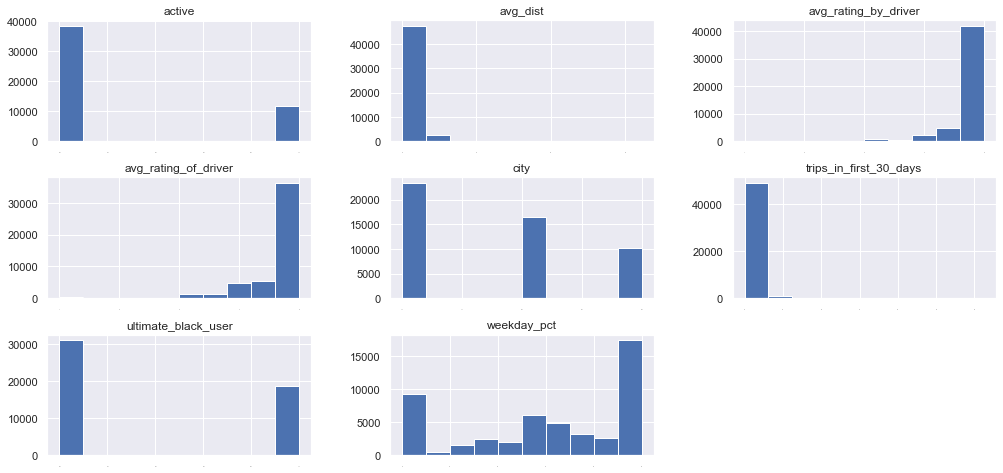

In [25]:
# Check distribution of data
users.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8));

#### Determine which variable scaler to use:
There are a two variable scalers that could used. 
- <b>Standard scaler:</b> Assumes the data is normally distributed and scales them to center around 0 and standard deviation of 1. However, from the above figure, almost none of the variables are normally distributed (especially the discretely coded variables).
- <b>Min-max scaler:</b> Shrinks range of each variable to (0,1) or (-1,1) if there are negative values. Works better for data that aren't normally distributed. 

According the the results of the figure above, the [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaler will be used.

In [27]:
# Scaling variables
from sklearn.preprocessing import MinMaxScaler

x = users.drop('active', axis=1)
y = users['active']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

<b>Approach:</b> Ultimate's goal is to predict rider retention. Presumably this means they would like to predict users at risk for churning and target them for marketing campaigns, discounts, getting in touch, etc. that would retain these users. 
- As a result, the predition model should emphasize minimizing false positives (churned users misclassified as 'active' and thus missed by marketing campaigns, etc), while balancing a reasonable amount of false negatives ('active' users misclassified as churners who would then get spammed with these marketing campaigns).

A few different classifiers will be analyzing the same data before picking the best-performing one and then optimizing the hyperparameters to improve performance.

In [28]:
# Split the data into train & test sets before modeling

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

In [32]:
# Utilizing L1 (Lasso) regression in case unimportant features can be eliminated from the prediction model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Instantiate model
model = LogisticRegression(penalty='l1', solver='liblinear') # instantiate logreg w/ l1 regularization
model.fit(X_train, y_train)
y_pred = model.predict(x_test)

# Generate confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[11230   202]
 [ 3280   288]]


According to the confusion matrix, 202 of churners were incorrectly labeled as 'active' users. There are also many active users misclassified as churners (false negatives of 3280). Other ML approaches will be used to see how they compare.

#### Customizing the scoring function

The other ML approaches will be aimed at reducing false positives (churned users incorrectly identified as 'active') while ensuring low false negative rates (active users incorrectly identified as churned) since too many active users would be incorrectly spammed to "retain" them. 

More accurately, the best prediction model will provide the best improvement over the previous logreg model (fp: 202, fn: 3280). Thus, a custom scoring function will be written to take any model with fp < 202, fn < 3280. Then, from this group of models, [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) identifies the model with lowest total fp + fn as the "best" model.

In [33]:
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

# Define scorer
def false_total(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    false_p = matrix[0,1]
    false_n = matrix[1,0]
    if ((false_p < 202) & (false_n < 2000)):
        falses = (false_p+false_n)/sum(sum(matrix))
        return falses
    else:
        falses = 1
        return falses

# Make scorer
scorer = make_scorer(false_total, greater_is_better=False)

#### Regular decision tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Decision tree
score = scorer
tuned_parameters = {'max_depth':range(2,7)}
model = DecisionTreeClassifier(min_samples_split=100, max_features='sqrt', random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=scorer, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 2} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2}
-1.000 (+/-0.000) for {'max_depth': 3}
-0.535 (+/-0.759) for {'max_depth': 4}
-1.000 (+/-0.000) for {'max_depth': 5}
-0.844 (+/-0.624) for {'max_depth': 6}

Detailed classification report:
[[11432     0]
 [ 3568     0]] 



Although there are 0 churned users incorrectly identified as 'active' now, there are still too many 'active' users incorrectly identified as churners. This means a lot of active customers will receive spam ads, and that will not be good for business. Other methods that are typically improved versions of decision trees will be tested.

#### Bagging

Constructs multiple trees and picks best-performing one.

In [38]:
%%time

from sklearn.ensemble import BaggingClassifier

score = scorer
tuned_parameters = {'n_estimators':range(30,91,10)}
model = BaggingClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'n_estimators': 30} 

Grid scores on development set:
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Detailed classification report:
[[10080  1352]
 [ 2274  1294]] 

Wall time: 2min 7s


There are 2274 false negatives (active users incorrectly identified as churned), and there are 1352 false positives (churned users missed and incorrectly labled as 'active').

#### Random forest

Constructs multiple decision trees (specified by 'n_estimators') and picks best one. When forming a tree, at each node a subset of features are randomly selected out of the total features. The best split feature from this subset is used to split the node (vs. bagging, where all features considered for splitting a node). 

In [39]:
%%time

from sklearn.ensemble import RandomForestClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10), 'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 6, 'min_samples_split': 900, 'n_estimators': 20} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 40}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 50}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 60}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 70}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 80}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 90}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
-0.232 

There are 2985 false negatives (active users incorrectly identified as churned), and there are 341 false positives (churned users missed and incorrectly labled as 'active').

#### AdaBoost

Gives weight to the misclassified data points. Might be useful since there are a disproportionately small number of active users that might be misclassified.

In [40]:
%%time

from sklearn.ensemble import AdaBoostClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10)}
model = AdaBoostClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'n_estimators': 20} 

Grid scores on development set:
-1.000 (+/-0.000) for {'n_estimators': 20}
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Detailed classification report:
[[10659   773]
 [ 2523  1045]] 

Wall time: 30 s


There are 2523 false negatives (active users incorrectly identified as churned), and there are 773 false positives (churned users missed and incorrectly labled as 'active').

#### Naive bayes

It is rooted in probability ([Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) and generates predictions based on past data. Given prior training data with features and labelled outcomes, what can be predicted with the set of test observations and their features? The label it predicts for each observation is based on its calculation of the likeliest out of the possible labels.

In [41]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Create the predicted tags: pred
y_true, y_pred = y_test, nb_classifier.predict(x_test)

print(confusion_matrix(y_true, y_pred))

[[11432     0]
 [ 3568     0]]


There are 3568 false negatives (active users incorrectly identified as churned), and there are 0 false positives (churned users missed and incorrectly labled as 'active'). These results are the same as the regular decision tree.

### Results:

The final model chosen as the prediction model is the <b>Random Forest Classifier</b>, with {'max_depth': 6, 'min_samples_split': 900, 'n_estimators': 20}. This balances the lowest number of false positives (341, churned users incorrectly identified as 'active') and false negatives (2985, 'active' users incorrectly identified as churned). 

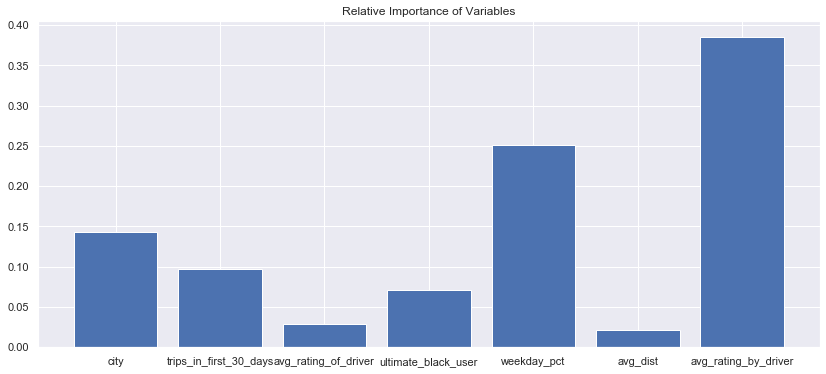

In [43]:
## Utilize the Random Forest Classifier to analyze the important variables
# Recreate the best model
model = RandomForestClassifier(max_depth=6, min_samples_split=900, n_estimators=20, random_state=99)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(x_test)

# Plot relative importance of features
plt.figure(figsize=(14,6));
plt.bar(users.columns[:-1].tolist(), model.feature_importances_);
plt.title('Relative Importance of Variables');

<b>Predicting churned users:</b> The final model chosen for the prediction model is a <b><i>Random Forest Classifier</i></b>, with {'max_depth': 6, 'min_samples_split': 900, 'n_estimators': 20}. This model does a good job of predicting churned users, with about 2.3% of churners being misclassified as 'active'. 
- The cost is that 19.9% of active users are misclassified as churners, which means they could receive marketing targeted towards churners. However, if this does not result in active users churning (presumably Ultimate adds value sufficiently that they are active users), then this is not necessarily an issue.
- Still, Ultimate should do further tests to determine how detrimental these false negatives are. Will active users necessarily churn because they receive ads as well? At what frequency of ads would active users begin to churn? A balance can probably be found and struck.

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

The variables of the data that were most predictive of 'active'/'inactive' were the <b><i>average rating by driver</b></i> and the <b><i>percent of user's trips occurring during weekday</b></i>. As a result, recommendations to Ultimate are:
- <b>Promote positive driver-rider interaction:</b> It seems lower average rating <i>by</i> driver would increase the risk for rider churning. Riders probably had dissatisfactory experiences with their riders. Encourage drivers to offer amenities that don't cost them much, such as water, candy, etc. Encourage them to ask a basic set of questions to improve rider mood/reduce likelihood of bad driver interaction, such as offering to roll down window, asking about AC, music, etc. Thus, the average rating by driver may improve, resulting in less churning by riders.<p>

- <b>Target churners with weekday discounts:</b> Based on the analysis, percent of user's trips during weekday is an important predictor of churning. Increasing churners' weekday trips may therefore improve the likelihood of them remaining as customers. This could be accomplished by offering them weekday discounts for their Ultimate trips, making Ultimate more of a weekday routine for them and therefore increasing the likelihood they will remain active users.<p>

- <b>Extend weekday discounts for "worst" churners:</b> Even if some churners only "stay" as long as there is a weekly discount, if Ultimate is not losing money on these customers that would otherwise not use their service and are price-sensitive, it may be useful to extend these discounts for select churners. It is recommended for Ultimate to identify the most price-sensitive churners.